# Create, evaluate, and score a churn prediction model

## Introduction

In this notebook, you'll see a Microsoft Fabric data science workflow with an end-to-end example. The scenario is to build a model to predict whether bank customers would churn or not. The churn rate, also known as the rate of attrition refers to the rate at which bank customers stop doing business with the bank.

The main steps in this notebook are:
1. Data collection
2. Data Journey and Data storeage
3. Data Augmentation
4. Data Validation
5. Understand and process the data through exploratory data analysis and demonstrate the use of Fabric Data Wrangler feature
6. Train machine learning models using `Scikit-Learn` and `LightGBM`, and track experiments using MLflow and Fabric Autologging feature
7. Evaluate and save the final machine learning model
8. Demonstrate the model performance via visualizations in Power BI


## Prerequisites
- [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to this notebook. You will be downloading data from a public blob, then storing the data in the lakehouse.

For this notebook, you'll install the `imblearn` using `%pip install`. Note that the PySpark kernel will be restarted after `%pip install`, thus you'll need to install the library before you run any other cells.

In [1]:
# Use pip to install imblearn for SMOTE
%pip install imblearn

## Step 1: Data Collection


![Image of Data Collection](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*MTWLp_V79poGSZ9W1bHGZA.png)

Data collection is the process of gathering and measuring information on variables of interest, in an established systematic fashion

### 1. Data Sources Identification

#### Internal Sources:
- **Transactional Data:** Includes all customer transactions, such as deposits, withdrawals, and payments. This data often resides in transaction processing systems.
- **Customer Interaction Data:** Information from CRM systems, including customer service interactions, feedback, and complaints.
- **Account Information:** Details about the type and number of products each customer holds, account opening date, and account status.

#### External Sources:
- **Credit Scores:** Often obtained from credit bureaus or external credit scoring agencies.
- **Demographic Data:** Additional demographic information might be collected from third-party providers to enrich the customer profiles.

### 2. Data Collection Mechanisms

#### Automated Data Collection:
- **APIs:** For external data, APIs can be used to pull information from third-party services (like credit bureaus).
- **Web Scraping:** To collect publicly available information or additional data from external websites that could enhance the customer profile.

#### Manual Data Entry:
- **Forms and Applications:** Data entered by customers on applications or forms, either online or in paper form, needs to be digitized and integrated into the bank’s data systems.

### 3. Data Ingestion

#### Batch Processing:
- **Scheduled Imports:** Data from systems like CRM or external databases is imported at regular intervals (e.g., nightly, weekly).

#### Real-Time Processing:
- **Streaming Data:** Transactional data might be streamed in real-time for immediate analysis, such as detecting fraud or high-value transactions that could indicate a risk of churn.

### 4. Data Verification and Validation

- **Consistency Checks:** Ensure data across different sources is consistent, e.g., the same customer is identified similarly across all datasets.
- **Accuracy Checks:** Validate that data like credit scores or personal information is accurately recorded and reflects the true state of affairs.

## Step 2: Data Journey and Data Storage



### Dataset

The dataset contains churn status of 10,000 customers along with 14 attributes that include credit score, geographical location (Germany, France, Spain), gender (male, female), age, tenure (years of being bank's customer), account balance, estimated salary, number of products that a customer has purchased through the bank, credit card status (whether a customer has a credit card or not), and active member status (whether an active bank's customer or not).

The dataset also includes columns such as row number, customer ID, and customer surname that should have no impact on customer's decision to leave the bank. The event that defines the customer's churn is the closing of the customer's bank account, therefore, the column `exit` in the dataset refers to customer's abandonment. Since you don't have much context about these attributes, you'll proceed without having background information about the dataset. Your aim is to understand how these attributes contribute to the `exit` status.

Out of the 10,000 customers, only 2037 customers (around 20%) have left the bank. Therefore, given the class imbalance ratio, it is recommended to generate synthetic data.

- churn.csv

|"CustomerID"|"Surname"|"CreditScore"|"Geography"|"Gender"|"Age"|"Tenure"|"Balance"|"NumOfProducts"|"HasCrCard"|"IsActiveMember"|"EstimatedSalary"|"Exited"|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|15634602|Hargrave|619|France|Female|42|2|0.00|1|1|1|101348.88|1|
|15647311|Hill|608|Spain|Female|41|1|83807.86|1|0|1|112542.58|0|




### Download dataset and upload to lakehouse

> [!TIP]
> By defining the following parameters, you can use this notebook with different datasets easily.


In [ ]:
IS_CUSTOM_DATA = False  # if TRUE, dataset has to be uploaded manually

IS_SAMPLE = False  # if TRUE, use only SAMPLE_ROWS of data for training, otherwise use all data
SAMPLE_ROWS = 5000  # if IS_SAMPLE is True, use only this number of rows for training

DATA_ROOT = "/lakehouse/default"
DATA_FOLDER = "Files/churn"  # folder with data files
DATA_FILE = "churn.csv"  # data file name

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 51, Finished, Available)



This code downloads a publicly available version of the dataset and then stores it in a Fabric lakehouse.

> [!IMPORTANT]
> **Make sure you [add a lakehouse](https://aka.ms/fabric/addlakehouse) to the notebook before running it. Failure to do so will result in an error.**

In [ ]:
import os, requests
if not IS_CUSTOM_DATA:
# Using synapse blob, this can be done in one line

# Download demo data files into lakehouse if not exist
    remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/bankcustomerchurn"
    file_list = ["churn.csv"]
    download_path = "/lakehouse/default/Files/churn/raw"

    if not os.path.exists("/lakehouse/default"):
        raise FileNotFoundError(
            "Default lakehouse not found, please add a lakehouse and restart the session."
        )
    os.makedirs(download_path, exist_ok=True)
    for fname in file_list:
        if not os.path.exists(f"{download_path}/{fname}"):
            r = requests.get(f"{remote_url}/{fname}", timeout=30)
            with open(f"{download_path}/{fname}", "wb") as f:
                f.write(r.content)
    print("Downloaded demo data files into lakehouse.")

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 52, Finished, Available)

Downloaded demo data files into lakehouse.


### Medallion Architecture

![Medallion Architecture](https://www.databricks.com/sites/default/files/inline-images/building-data-pipelines-with-delta-lake-120823.png)

A medallion architecture is a data design pattern used to logically organize data in a lakehouse, with the goal of incrementally and progressively improving the structure and quality of data as it flows through each layer of the architecture (from Bronze ⇒ Silver ⇒ Gold layer tables). Medallion architectures are sometimes also referred to as "multi-hop" architectures.


### Medallion Architecture in the Context of Churn Prediction

The Medallion Architecture, also known as the Data Mesh, consists of three layers that structure data processing and storage in a way that optimizes for scalability, accessibility, and reliability. Here's how these layers can be utilized for your dataset in the context of churn prediction:

#### 1. Bronze Layer (Raw Data Layer)
- **Purpose:** This layer stores raw data as it is ingested from various sources. For churn prediction, this includes all the raw customer data collected by the bank.
- **Data Science Usage:** Data scientists use this layer for initial data exploration and quality checks. They can assess the completeness and accuracy of the raw data, including identifying any missing values or anomalies.

#### 2. Silver Layer (Cleansed Data Layer)
- **Purpose:** Data in this layer is cleansed, transformed, and enriched to make it ready for analysis. This involves preprocessing steps like handling missing values, encoding categorical variables, and feature scaling.
- **Data Science Usage:** The cleansed and processed data in this layer is used for more detailed analysis and model training. Data scientists can start building predictive models using this refined data, optimizing features to better predict customer churn.

#### 3. Gold Layer (Aggregated Data Layer)
- **Purpose:** This layer contains highly aggregated and summarized data. For churn prediction, it could include customer segments identified as high risk, summary statistics like average churn rate by demographic, or the results of predictive models.
- **Data Science Usage:** Data scientists and business analysts use this layer for generating insights, reporting, and decision-making. It is also where predictive insights are operationalized, allowing for strategic actions like targeted customer retention campaigns.

### Read raw data from the lakehouse

Reads raw data from the **Files** section of the lakehouse, adds additional columns for different date parts and the same information will be used to create partitioned delta table.

In [10]:
df = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv("Files/churn/raw/churn.csv")
    .cache()
).toPandas()

NameError: name 'spark' is not defined

### Simplistic Demonstration of Medallion Architecture

In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Step 1: Load raw data into the Bronze layer
bronze_data = pd.read_csv('Files/churn/raw/churn.csv')
print(
  f"Loaded {bronze_data.shape[0]} rows and {bronze_data.shape[1]} columns from the raw data."
)

display(bronze_data)

# Step 2: Clean and preprocess data to move to the Silver layer
# Remove irrelevant columns
silver_data = bronze_data.drop(columns=['CustomerId', 'Surname', 'RowNumber'])

# Convert categorical data to numeric
le = LabelEncoder()
silver_data['Geography'] = le.fit_transform(silver_data['Geography'])
silver_data['Gender'] = le.fit_transform(silver_data['Gender'])

# Handle missing values (assuming fill with median for demonstration)
silver_data.fillna(silver_data.median(), inplace=True)

# Standardize continuous variables
scaler = StandardScaler()
silver_data[['Age', 'CreditScore', 'Tenure', 'Balance', 'EstimatedSalary']] = scaler.fit_transform(
    silver_data[['Age', 'CreditScore', 'Tenure', 'Balance', 'EstimatedSalary']]
)
print(
    f"Converted {silver_data.shape[0]} rows and {silver_data.shape[1]} columns from the bronze data to the silver data."
)
display(silver_data)

# Step 3: Create aggregated data for the Gold layer
gold_data = silver_data.groupby('Exited').agg({
    'CreditScore': ['mean', 'std'],
    'Balance': ['mean', 'std'],
    'Age': ['mean', 'std'],
    'NumOfProducts': ['count']
})
print(
    f"Created {gold_data.shape[0]} rows and {gold_data.shape[1]} columns from the silver data to the gold data."
)
# Data is now ready for high-level analysis and reporting
display(gold_data)

Loaded 10000 rows and 14 columns from the raw data.


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Converted 10000 rows and 11 columns from the bronze data to the silver data.


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,-0.326221,0,0,0.293517,-1.041760,-1.225848,1,1,1,0.021886,1
1,-0.440036,2,0,0.198164,-1.387538,0.117350,1,0,1,0.216534,0
2,-1.536794,0,0,0.293517,1.032908,1.333053,3,1,0,0.240687,1
3,0.501521,0,0,0.007457,-1.387538,-1.225848,2,0,0,-0.108918,0
4,2.063884,2,0,0.388871,-1.041760,0.785728,1,1,1,-0.365276,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,1.246488,0,1,0.007457,-0.004426,-1.225848,2,1,0,-0.066419,0
9996,-1.391939,0,1,-0.373958,1.724464,-0.306379,1,1,1,0.027988,0
9997,0.604988,0,0,-0.278604,0.687130,-1.225848,1,0,1,-1.008643,1
9998,1.256835,1,1,0.293517,-0.695982,-0.022608,2,1,0,-0.125231,1


Created 2 rows and 7 columns from the silver data to the gold data.


CreditScore             Balance                 Age           \
              mean       std      mean       std      mean      std   
Exited                                                                
0         0.013703  0.989709 -0.059951  1.007272 -0.144309  0.96549   
1        -0.053568  1.038004  0.234359  0.935355  0.564131  0.93080   

       NumOfProducts  
               count  
Exited                
0               7963  
1               2037

## Step 3: Data Cleaning and Preprocessing
- **Location:** Silver Layer
- **Why:** The Silver Layer is for cleansed and transformed data, making it suitable for data cleaning and preprocessing to prepare data for analysis and modeling.



In [ ]:
def clean_data(df):
    # Drop rows with missing data across all columns
    df.dropna(inplace=True)
    # Drop duplicate rows in columns: 'RowNumber', 'CustomerId'
    df.drop_duplicates(subset=['RowNumber', 'CustomerId'], inplace=True)
    # Drop columns: 'RowNumber', 'CustomerId', 'Surname'
    df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
    return df

df_clean = clean_data(df.copy())

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 55, Finished, Available)

In [ ]:
# if IS_SAMPLE is True, use only SAMPLE_ROWS of rows for training
if IS_SAMPLE:
    df_clean = df_clean.limit(SAMPLE_ROWS)

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 56, Finished, Available)

## Step 4: Data Augumentation - Demonstrated in Step 7

- **Location:** Silver Layer
- **Why:** Data augmentation typically takes place after initial data cleaning and preprocessing (still in the Silver layer) because it requires a processed dataset to generate meaningful synthetic data. The augmented dataset is then used for training models, which is also a part of the Silver layer activities before moving the trained models and their insights into the Gold layer for deployment and decision-making.

## Step 5: Data Analysis and Exploratory Data Analysis (EDA)
- **Location:** Silver Layer
- **Why:** EDA involves analyzing the cleansed and processed data to uncover patterns and check assumptions, suited to the Silver Layer.

### Display raw data

Explore the raw data with `display`, do some basic statistics and show chart views. You first need to import required libraries for data visualization such as `seaborn` which is a Python data visualization library to provide a high-level interface for building visuals on dataframes and arrays. Learn more about [`seaborn`](https://seaborn.pydata.org/).

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="tab10", rc = {'figure.figsize':(9,6)})
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rc, rcParams
import numpy as np
import pandas as pd
import itertools

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 57, Finished, Available)

In [ ]:
display(df, summary=True)

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 58, Finished, Available)

SynapseWidget(Synapse.DataFrame, 13421cb3-ab69-482e-927c-3cda6d8f452f)

##### Determine attributes

Use this code to determine categorical, numerical, and target attributes.

In [ ]:
# Determine the dependent (target) attribute
dependent_variable_name = "Exited"
print(dependent_variable_name)
# Determine the categorical attributes
categorical_variables = [col for col in df_clean.columns if col in "O"
                        or df_clean[col].nunique() <=5
                        and col not in "Exited"]
print(categorical_variables)
# Determine the numerical attributes
numeric_variables = [col for col in df_clean.columns if df_clean[col].dtype != "object"
                        and df_clean[col].nunique() >5]
print(numeric_variables)

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 59, Finished, Available)

Exited
['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']



##### The five-number summary

Show the five-number summary (the minimum score, first quartile, median, third quartile, the maximum score) for the numerical attributes, using box plots.

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 60, Finished, Available)

/tmp/ipykernel_19629/2095287195.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


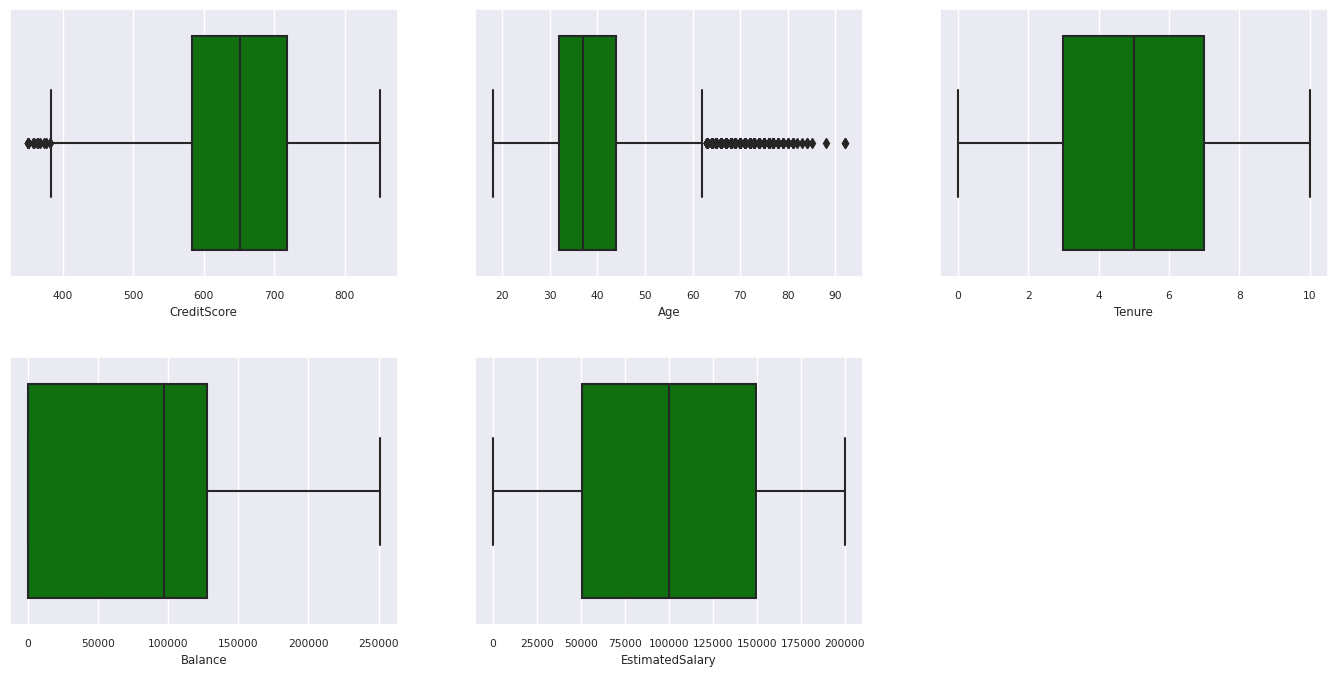

In [ ]:
df_num_cols = df_clean[numeric_variables]
sns.set(font_scale = 0.7)
fig, axes = plt.subplots(nrows = 2, ncols = 3, gridspec_kw =  dict(hspace=0.3), figsize = (17,8))
fig.tight_layout()
for ax,col in zip(axes.flatten(), df_num_cols.columns):
    sns.boxplot(x = df_num_cols[col], color='green', ax = ax)
# fig.suptitle('visualize and compare the distribution and central tendency of numerical attributes', color = 'k', fontsize = 12)
fig.delaxes(axes[1,2])


##### Distribution of exited and non-exited customers

Show the distribution of exited versus non-exited customers across the categorical attributes.

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 61, Finished, Available)

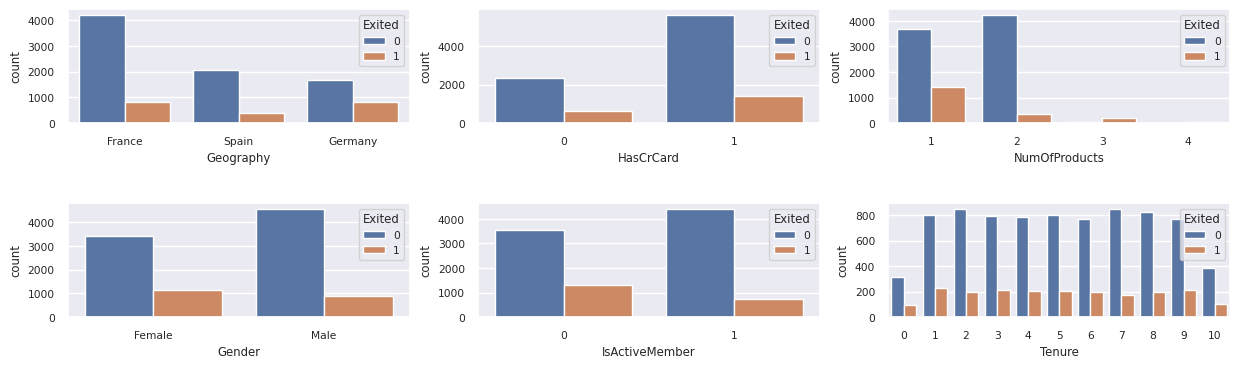

In [ ]:
attr_list = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure']
fig, axarr = plt.subplots(2, 3, figsize=(15, 4))
for ind, item in enumerate (attr_list):
    sns.countplot(x = item, hue = 'Exited', data = df_clean, ax = axarr[ind%2][ind//2])
fig.subplots_adjust(hspace=0.7)

##### Distribution of numerical attributes

Show the the frequency distribution of numerical attributes using histogram.


StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 62, Finished, Available)

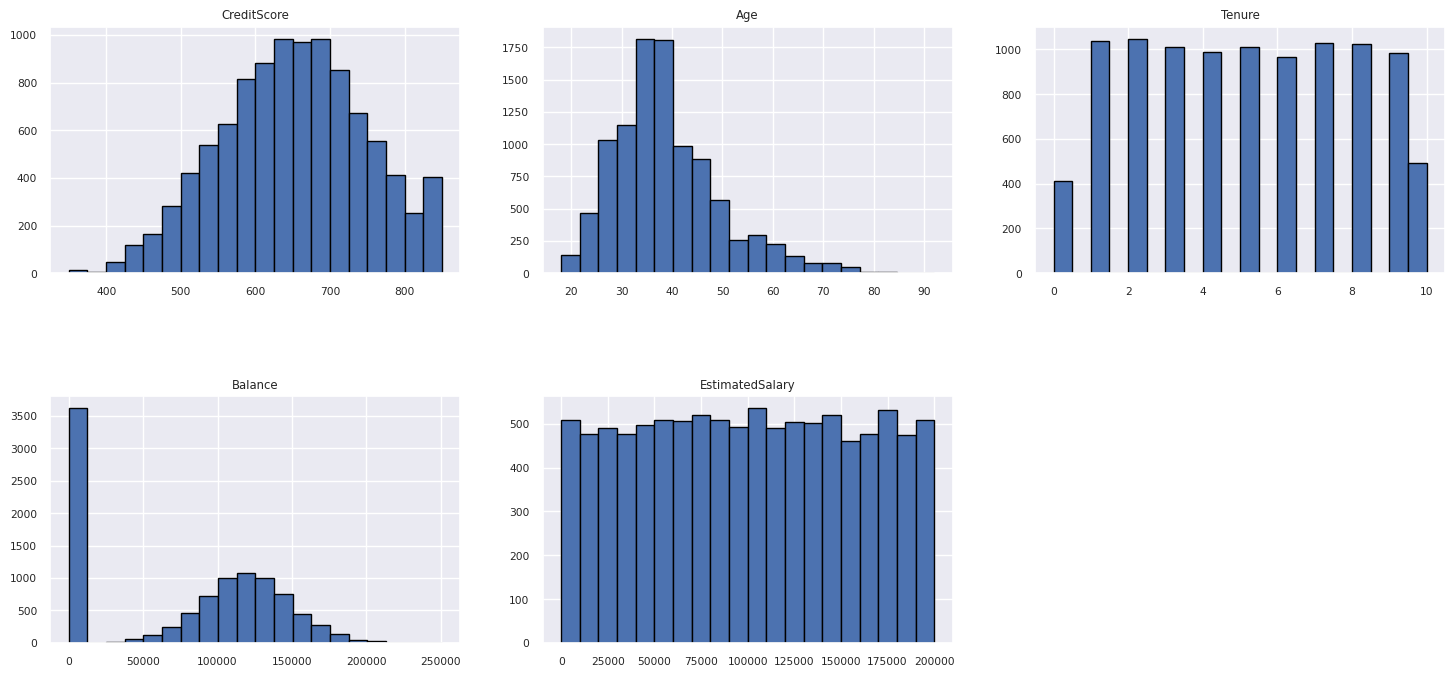

In [ ]:
columns = df_num_cols.columns[: len(df_num_cols.columns)]
fig = plt.figure()
fig.set_size_inches(18, 8)
length = len(columns)
for i,j in itertools.zip_longest(columns, range(length)):
    plt.subplot((length // 2), 3, j+1)
    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
    df_num_cols[i].hist(bins = 20, edgecolor = 'black')
    plt.title(i)
# fig = fig.suptitle('distribution of numerical attributes', color = 'r' ,fontsize = 14)
plt.show()

### Summary of observations from the exploratory data analysis

- Most of the customers are from France comparing to Spain and Germany, while Spain has the lower churn rate comparing to France and Germany.
- Most of the customers have credit cards.
- There are customers whose age and credit score are above 60 and below 400, respectively, but they can't be considered as outliers.
- Very few customers have more than two of the bank's products.
- Customers who aren't active have a higher churn rate.
- Gender and tenure years don't seem to have an impact on customer's decision to close the bank account.

## Step 6: Feature Engineering
- **Location:** Silver Layer
- **Why:** Continues in the Silver Layer where new features are created from existing data to enhance the dataset further for predictive modeling.

![image (8).png](attachment:8a2c049a-444f-4a25-b058-41a7db8ca4df.png)

In [ ]:
df_clean = pd.get_dummies(df_clean, columns=['Geography', 'Gender'])

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 63, Finished, Available)

In [ ]:
df_clean.head()

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 64, Finished, Available)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,True,False,False,True,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,False,True,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,True,False,False,True,False
3,699,39,1,0.00,2,0,0,93826.63,0,True,False,False,True,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,False,True,True,False


In [ ]:
df_clean["NewTenure"] = df_clean["Tenure"]/df_clean["Age"]
df_clean["NewCreditsScore"] = pd.qcut(df_clean['CreditScore'], 6, labels = [1, 2, 3, 4, 5, 6])
df_clean["NewAgeScore"] = pd.qcut(df_clean['Age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
df_clean["NewBalanceScore"] = pd.qcut(df_clean['Balance'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
df_clean["NewEstSalaryScore"] = pd.qcut(df_clean['EstimatedSalary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 65, Finished, Available)

### Create a delta table to generate the Power BI report

In [ ]:
table_name = "df_clean"
# Create PySpark DataFrame from Pandas
sparkDF=spark.createDataFrame(df_clean)
sparkDF.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 66, Finished, Available)

Spark dataframe saved to delta table: df_clean


## Step 7: Model Training and Tracking
- **Location:** Silver Layer
- **Why:** Model training requires processed, clean data, making the Silver Layer the ideal place due to its stability and consistency in data quality.



With your data in place, you can now define the model. You'll apply Random Forrest and LightGBM models in this notebook.

Use `scikit-learn` and `lightgbm` to implement the models within a few lines of code. Also use MLfLow and Fabric Autologging to track the experiments.

Here you'll load the delta table from the lakehouse. You may use other delta tables considering the lakehouse as the source.

In [ ]:
SEED = 12345
df_clean = spark.read.format("delta").load("Tables/df_clean").toPandas()

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 67, Finished, Available)

### Generate experiment for tracking and logging the models using MLflow

This section demonstrates how to generate an experiment, specify model and training parameters as well as scoring metrics, train the models, log them, and save the trained models for later use.

In [ ]:
import mlflow

# Set up experiment name
EXPERIMENT_NAME = "sample-bank-churn-experiment"  # MLflow experiment name

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 68, Finished, Available)

Extending the MLflow autologging capabilities, autologging works by automatically capturing the values of input parameters and output metrics of a machine learning model as it is being trained. This information is then logged to your workspace, where it can be accessed and visualized using the MLflow APIs or the corresponding experiment in your workspace. To learn more about  autologging, see  [Autologging in Microsoft Fabric](https://aka.ms/fabric-autologging).

### Set experiment and autologging specifications

In [ ]:
mlflow.set_experiment(EXPERIMENT_NAME) # Use date stamp to append to experiment
mlflow.autolog(exclusive=False)

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 69, Finished, Available)

2024/05/08 18:53:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/05/08 18:53:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


### Import scikit-learn and LightGBM

In [ ]:
# Import the required libraries for model training
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score, roc_auc_score, classification_report

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 70, Finished, Available)

2024/05/08 18:54:13 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/05/08 18:54:13 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


### Prepare training and test datasets

In [ ]:
y = df_clean["Exited"]
X = df_clean.drop("Exited",axis=1)
# Train-Test Separation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 71, Finished, Available)

### Introduction to SMOTE

The problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. Synthetic Minority Oversampling Technique (SMOTE) is the most widely used approach to synthesize new samples for the minority class. Learn more about SMOTE [here](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#) and [here](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn).

You will be able to access SMOTE using the `imblearn` library that you installed in Step 1.

##### Apply SMOTE to the training data to synthesize new samples for the minority class

SMOTE should only be applied to the training dataset. You must leave the test dataset in its original imbalanced distribution in order to get a valid approximation of how the model will perform on the original data, which is representing the situation in production.

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=SEED)
X_res, y_res = sm.fit_resample(X_train, y_train)
new_train = pd.concat([X_res, y_res], axis=1)

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 72, Finished, Available)

2024/05/08 18:54:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9f4c8501-3b72-40af-969a-1d908d5b71af', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024-05-08:18:54:55,393 WARNING  [tracking_store.py:153] log_inputs not supported
2024/05/08 18:54:56 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/05/08 18:54:56 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/05/08 18:54:56 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/05/08 18:55:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/ho

### Model training

Train the model using Random Forest with maximum depth of four, with four features.

In [ ]:
mlflow.sklearn.autolog(registered_model_name='rfc1_sm')  # Register the trained model with autologging
rfc1_sm = RandomForestClassifier(max_depth=4, max_features=4, min_samples_split=3, random_state=1) # Pass hyperparameters
with mlflow.start_run(run_name="rfc1_sm") as run:
    rfc1_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    print("run_id: {}; status: {}".format(rfc1_sm_run_id, run.info.status))
    # rfc1.fit(X_train,y_train) # imbalanaced training data
    rfc1_sm.fit(X_res, y_res.ravel()) # balanced training data
    rfc1_sm.score(X_test, y_test)
    y_pred = rfc1_sm.predict(X_test)
    cr_rfc1_sm = classification_report(y_test, y_pred)
    cm_rfc1_sm = confusion_matrix(y_test, y_pred)
    roc_auc_rfc1_sm = roc_auc_score(y_res, rfc1_sm.predict_proba(X_res)[:, 1])

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 73, Finished, Available)

2024/05/08 18:55:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024-05-08:18:55:16,690 WARNING  [tracking_store.py:153] log_inputs not supported
2024/05/08 18:55:18 WARNING mlf

run_id: d2a22cef-f58f-47d4-a39a-1d6e6c7d4aac; status: RUNNING


Train the model using Random Forest with maximum depth of eight, with six features.

In [ ]:
mlflow.sklearn.autolog(registered_model_name='rfc2_sm')  # Register the trained model with autologging
rfc2_sm = RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3, random_state=1) # Pass hyperparameters
with mlflow.start_run(run_name="rfc2_sm") as run:
    rfc2_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    print("run_id: {}; status: {}".format(rfc2_sm_run_id, run.info.status))
    # rfc2.fit(X_train,y_train) # imbalanced training data
    rfc2_sm.fit(X_res, y_res.ravel()) # balanced training data
    rfc2_sm.score(X_test, y_test)
    y_pred = rfc2_sm.predict(X_test)
    cr_rfc2_sm = classification_report(y_test, y_pred)
    cm_rfc2_sm = confusion_matrix(y_test, y_pred)
    roc_auc_rfc2_sm = roc_auc_score(y_res, rfc2_sm.predict_proba(X_res)[:, 1])

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 74, Finished, Available)

2024/05/08 18:56:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024-05-08:18:56:00,380 WARNING  [tracking_store.py:153] log_inputs not supported
2024/05/08 18:56:03 WARNING mlf

run_id: 19587603-deed-4848-966c-b8128c9cbefd; status: RUNNING


Train the model using LightGBM.

In [ ]:
# lgbm_model
mlflow.lightgbm.autolog(registered_model_name='lgbm_sm')  # Register the trained model with autologging
lgbm_sm_model = LGBMClassifier(learning_rate = 0.07,
                        max_delta_step = 2,
                        n_estimators = 100,
                        max_depth = 10,
                        eval_metric = "logloss",
                        objective='binary',
                        random_state=42)

with mlflow.start_run(run_name="lgbm_sm") as run:
    lgbm1_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    # lgbm_sm_model.fit(X_train,y_train) # imbalanced training data
    lgbm_sm_model.fit(X_res, y_res.ravel()) # balanced training data
    y_pred = lgbm_sm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cr_lgbm_sm = classification_report(y_test, y_pred)
    cm_lgbm_sm = confusion_matrix(y_test, y_pred)
    roc_auc_lgbm_sm = roc_auc_score(y_res, lgbm_sm_model.predict_proba(X_res)[:, 1])

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 85, Finished, Available)

2024/05/08 19:15:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024-05-08:19:15:46,47 WARNING  [tracking_store.py:153] log_inputs not supported
2024/05/08 19:15:47 WARNING mlfl

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6353, number of negative: 6353
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 12706, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_lea

### Experiments artifact for tracking model performance

The experiment runs are automatically saved in the experiment artifact that can be found from the workspace. They're named based on the name used for setting the experiment. All of the trained models, their runs, performance metrics and model parameters are logged as can be seen from the experiment page shown in the image below.   

To view your experiments:
1. On the left panel, select your workspace.
1. Find and select the experiment name, in this case _sample-bank-churn-experiment_.

<img src="https://synapseaisolutionsa.blob.core.windows.net/public/bankcustomerchurn/experiment_runs.png"  width="400%" height="100%" title="Screenshot shows logged values for one of the models.">

## Step 8: Evaluate and save the final machine learning model


Open the saved experiment from the workspace to select and save the best model.

In [ ]:
# Define run_uri to fetch the model
# mlflow client: mlflow.model.url, list model
load_model_rfc1_sm = mlflow.sklearn.load_model(f"runs:/{rfc1_sm_run_id}/model")
load_model_rfc2_sm = mlflow.sklearn.load_model(f"runs:/{rfc2_sm_run_id}/model")
load_model_lgbm1_sm = mlflow.lightgbm.load_model(f"runs:/{lgbm1_sm_run_id}/model")

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 76, Finished, Available)

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 77, Finished, Available)

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 78, Finished, Available)

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 79, Finished, Available)

### Assess the performances of the saved models on test dataset

In [ ]:
ypred_rfc1_sm = load_model_rfc1_sm.predict(X_test) # Random Forest with max depth of 4 and 4 features
ypred_rfc2_sm = load_model_rfc2_sm.predict(X_test) # Random Forest with max depth of 8 and 6 features
ypred_lgbm1_sm = load_model_lgbm1_sm.predict(X_test) # LightGBM

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 80, Finished, Available)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


### Show True/False Positives/Negatives using the Confusion Matrix

Develop a script to plot the confusion matrix in order to evaluate the accuracy of the classification. You can also plot a confusion matrix using SynapseML tools, which is shown in the [Fraud Detection sample](https://aka.ms/samples/frauddectection).

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    print(cm)
    plt.figure(figsize=(4,4))
    plt.rcParams.update({'font.size': 10})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 81, Finished, Available)

Create a confusion matrix for Random Forest Classifier with maximum depth of four, with four features.


StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 82, Finished, Available)

[[1389  221]
 [ 144  246]]


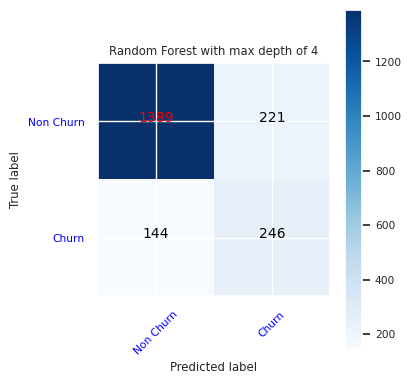

In [ ]:
cfm = confusion_matrix(y_test, y_pred=ypred_rfc1_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Random Forest with max depth of 4')
tn, fp, fn, tp = cfm.ravel()

Create a confusion matrix for Random Forest Classifier with maximum depth of eight, with six features.

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 83, Finished, Available)

[[1460  150]
 [ 149  241]]


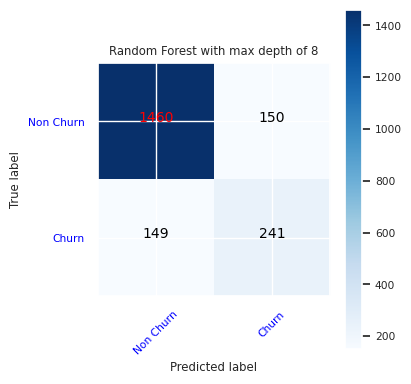

In [ ]:
cfm = confusion_matrix(y_test, y_pred=ypred_rfc2_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Random Forest with max depth of 8')
tn, fp, fn, tp = cfm.ravel()

Create the confusion matrix for LightGBM.

StatementMeta(, 6a641aa0-deaf-4a58-90ef-f9f974aea84b, 84, Finished, Available)

[[1503  107]
 [ 157  233]]


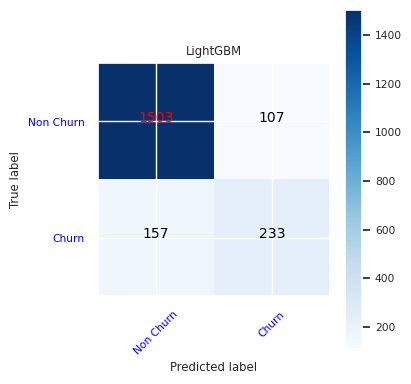

In [ ]:
cfm = confusion_matrix(y_test, y_pred=ypred_lgbm1_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='LightGBM')
tn, fp, fn, tp = cfm.ravel()